In [1]:
#!pip install janome

import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from torch import nn, Tensor
import torch.nn.functional as F
#from torchtext.vocab import vocab
#import torchtext.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import math
import janome
from janome.tokenizer import Tokenizer
#import spacy
from collections import Counter
from torch.utils.data.sampler import SubsetRandomSampler
import time
#from torchtext.vocab import build_vocab_from_iterator
import levenshtein
import json
import pickle
from timm.scheduler import CosineLRScheduler
from nltk import bleu_score
import sys

sys.path.append('./RetNet-main/src/')

from torchscale.architecture.config import RetNetConfig
from torchscale.architecture.retnet import RetNetDecoder
#from torchscale.architecture.config import EncoderConfig
#from torchscale.architecture.encoder import Encoder

In [2]:
import json

token_list_path = "20240531_ntt_idx_to_wakati_auto.json"
with open( token_list_path, mode="r" , encoding="utf-8" ) as f:
    token_list = json.load( f )

token_list_en_path = "20240531_ntt_idx_to_word_auto.json"
with open( token_list_en_path, mode="r" , encoding="utf-8" ) as f:
    token_list_en = json.load( f )

idx_list_path = "20240531_ntt_wakati_to_idx_auto.json"
with open( idx_list_path, mode="r" , encoding="utf-8" ) as f:
    idx_list = json.load( f )

idx_list_en_path = "20240531_ntt_word_to_idx_auto.json"
with open( idx_list_en_path, mode="r" , encoding="utf-8" ) as f:
    idx_list_en = json.load( f )
    
enc_vocab_size, dec_vocab_size = len(token_list) - 1, len(token_list_en) - 1
print(enc_vocab_size, dec_vocab_size)

184855 181271


In [3]:
a = torch.tensor( [ 0,1,2,3,4,5,6 ])

b = [ token_list[str(i.item())] for i in a ]

print( b )


d = idx_list['<pad>']

print( d )

['<pad>', '<bos>', '<eos>', '<unk>', '鼻', '・', '口']
0


In [4]:
# -*- coding: utf-8 -*-

#
# Pytorchで用いるDatasetの定義
#

# PytorchのDatasetモジュールをインポート
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

# 数値演算用モジュール(numpy)をインポート
import numpy as np

# sysモジュールをインポート
import sys


class SequenceDataset(Dataset):
    ''' ミニバッチデータを作成するクラス
        torch.utils.data.Datasetクラスを継承し，
        以下の関数を定義する
        __len__: 総サンプル数を出力する関数
        __getitem__: 1サンプルのデータを出力する関数
    feat_scp:  特徴量リストファイル
    label_scp: ラベルファイル
    feat_mean: 特徴量の平均値ベクトル
    feat_std:  特徴量の次元毎の標準偏差を並べたベクトル 
    pad_index: バッチ化の際にフレーム数を合わせる
               ためにpaddingする整数値
    splice:    前後(splice)フレームを特徴量を結合する
               splice=1とすると，前後1フレーム分結合
               するので次元数は3倍になる．
               splice=0の場合は何もしない
    '''
    def __init__(self, 
                 filename,
                 pad_index_j=idx_list['<pad>'],
                 pad_index_e=idx_list_en['<pad>'],
                 ):

        # 特徴量リスト，ラベルを1行ずつ
        # 読み込みながら情報を取得する
        self.pad_index_j = pad_index_j
        self.pad_index_e = pad_index_e
        #self.ens = []
        self.en_list = []
        self.en_lens = []
        #self.jps = []
        self.jp_list = []
        self.jp_lens = []
        self.num_data = 0
        with open(filename, mode='r', encoding="utf-8") as file_f:
            for line in file_f:
                line = line.replace( "\n", "" )
                # 各行をスペースで区切り，
                # リスト型の変数にする
                #print( "line:", line)
                en = line.split("\t")[1]
                #self.ens.append( en )
                #self.ens = self.ens
                en1 = en.split( ' ' )
                self.en_list.append( en1 )
                self.en_lens.append( len( en1 ) )

                jp = line.split("\t")[0]
                #self.jps.append( jp )
                #self.jps = self.jps
                jp1 = jp.split( ' ' )
                self.jp_list.append( jp1 )
                self.jp_lens.append( len( jp1 ) )
                self.num_data += 1

        self.en_lens = np.int64( np.array( self.en_lens ) )
        self.jp_lens = np.int64( np.array( self.jp_lens ) )


        # フレーム数の最大値を得る
        self.max_en_len = np.max(self.en_lens)
        # ラベル長の最大値を得る
        self.max_jp_len = np.max(self.jp_lens)

        # ラベルデータの長さを最大フレーム長に
        # 合わせるため，pad_indexの値で埋める
        for n in range(self.num_data):
            if n % 10000 == 0:
                print( "n:", n )
            # 埋めるフレームの数
            # = 最大フレーム数 - 自分のフレーム数
            pad_len = self.max_en_len \
                    - self.en_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            tmp = self.en_list[n]
            self.en_list[n] = np.pad( tmp, (0, pad_len), mode='constant', constant_values=(self.pad_index_e, self.pad_index_e ))
            #print( self.en_list[n][0].dtype )
            #tmp = torch.tensor( self.en_list[n] )
            #tmp = F.pad( tmp, (0, pad_len), 'constant', self.pad_index_e )
            #self.en_list[n] = tmp.to('cpu').detach().numpy().copy()
            #print( self.en_list[n] )
            #tmp = torch.tensor( self.en_list[n] )
            #if torch.any( tmp == 5785 ):
            #    print( "tmp == 5785" )
            pad_len = self.max_jp_len \
                    - self.jp_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            self.jp_list[n] = np.pad(self.jp_list[n],[0, pad_len],mode='constant', constant_values=self.pad_index_j)

        self.en_list = np.int64( np.array( self.en_list ) )
        self.jp_list = np.int64( np.array( self.jp_list ) )
        #print( self.jp_list )

        #max = np.max( self.jp_list, axis =1 )
        #maxmax = np.max( max )
        #print( "maxmax:{}".format(maxmax) )


    def __len__(self):
        ''' 学習データの総サンプル数を返す関数
        本実装では発話単位でバッチを作成するため，
        総サンプル数=発話数である．
        '''
        return self.num_data


    def __getitem__(self, idx):
        ''' サンプルデータを返す関数
        本実装では発話単位でバッチを作成するため，
        idx=発話番号である．
        '''
        # 特徴量系列のフレーム数
        jp_len = self.jp_lens[idx]
        # ラベルの長さ
        en_len = self.en_lens[idx]

        # ラベル
        jp = self.jp_list[idx]
        #print( jp )
        #jp = np.fromfile(self.jp_list[idx],dtype=np.int64)

        # 発話ID
        en = self.en_list[idx]
        #ens = np.fromfile(self.en_list[idx],dtype=np.float32)

        #batch = {}
        #batch['jp'] = jp
        #batch['en'] = en
        #batch['jp_len'] = jp_len
        #batch['en_len'] = en_len


        # 特徴量，ラベル，フレーム数，
        # ラベル長，発話IDを返す
        #return (jps, jp_lens, ens,  en_lens)
        return (jp, en, jp_len, en_len )

In [5]:
BATCH_SIZE = 10
batch_size = BATCH_SIZE

train_dataset = SequenceDataset( "20240531_ntt_ids_train_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )
#train_dataset = SequenceDataset( "20240531_ntt_ids_dev_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
val_dataset = SequenceDataset( "20240531_ntt_ids_dev_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
    
# 訓練データのDataLoaderを呼び出す
# 訓練データはシャッフルして用いる
#  (num_workerは大きい程処理が速くなりますが，
#   PCに負担が出ます．PCのスペックに応じて
#   設定してください)

num_workers = 4 if torch.cuda.is_available() else 0
#num_workers = 0

train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers)
# 開発データのDataLoaderを呼び出す
# 開発データはデータはシャッフルしない
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

print( len( train_loader ))
print( len( val_loader ))


text, target, text_len, target_len = next(iter(train_loader))
print(text[0], target[0], text_len[0],target_len[0], sep="\n")

n: 0
n: 10000
n: 20000
n: 30000
n: 40000
n: 50000
n: 60000
n: 70000
n: 80000
n: 90000
n: 100000
n: 110000
n: 120000
n: 130000
n: 140000
n: 150000
n: 160000
n: 170000
n: 180000
n: 190000
n: 200000
n: 210000
n: 220000
n: 230000
n: 240000
n: 250000
n: 260000
n: 270000
n: 280000
n: 290000
n: 300000
n: 310000
n: 320000
n: 330000
n: 340000
n: 350000
n: 360000
n: 370000
n: 380000
n: 390000
n: 400000
n: 410000
n: 420000
n: 430000
n: 440000
n: 450000
n: 460000
n: 470000
n: 480000
n: 490000
n: 500000
n: 510000
n: 520000
n: 530000
n: 540000
n: 550000
n: 560000
n: 570000
n: 580000
n: 590000
n: 600000
n: 610000
n: 620000
n: 630000
n: 640000
n: 650000
n: 660000
n: 670000
n: 680000
n: 690000
n: 700000
n: 710000
n: 720000
n: 730000
n: 740000
n: 750000
n: 760000
n: 770000
n: 780000
n: 790000
n: 800000
n: 810000
n: 820000
n: 830000
n: 840000
n: 850000
n: 860000
n: 870000
n: 880000
n: 890000
n: 900000
n: 910000
n: 920000
n: 930000
n: 940000
n: 950000
n: 960000
n: 970000
n: 980000
n: 990000
n: 0
100000
50

In [6]:
class RetNetModel(nn.Module):
    '''
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: FNNにおける中間特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, dim_embedding: int,
                 layers: int, heads: int, pad_index: int, up_rate: float, device = 'cpu' ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding( src_vocab_size, dim_embedding, padding_idx=pad_index)   

        config = RetNetConfig()
        config.decoder_embed_dim = dim_embedding
        config.decoder_ffn_embed_dim = dim_embedding * 4
        config.decoder_layers = layers
        config.decoder_retention_heads = heads
        embed_tokens = None
        output_projection = nn.Linear( dim_embedding, tgt_vocab_size ).to(device)
        self.retnet = RetNetDecoder(config, embed_tokens=embed_tokens, output_projection = output_projection).to(device)
        
        self.up_rate = up_rate

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, x: torch.Tensor ):

        x = self.embed( x )
        
        x = x.transpose( 1, 2 )
        x = F.interpolate( x, size = None, scale_factor = self.up_rate )
        x = x.transpose( 1, 2 )

        # prev_output_tokens = None　とすると、MS の retnet.py の slen = prev_output_tokens.size() で NoneType error がでる。
        # このためｎ、prev_output_tokens に、シーケンス長が正しい dummy_tokens を渡す。retention の計算には、token_embeddings が使われる
        #　ため大丈夫。
        dummy_tokens = torch.zeros_like( x )[:,:,0]

        x = self.retnet( prev_output_tokens = dummy_tokens, token_embeddings = x )[0]

        #print( "x size:", x.size() )
        
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
d_model = 512
layers = 12
heads = 8
pad_idx = idx_list['<pad>']
up_rate = 2.0

    #def __init__(self, src_vocab_size: int, tgt_voacab_size: int, dim_embedding: int,
    #             layers: int, heads: int, pad_index: int, up_rate: float, device = 'cpu' ):

model = RetNetModel( enc_vocab_size, dec_vocab_size, d_model, layers, heads, pad_idx, up_rate, device ).to(device)

#criterion = nn.CrossEntropyLoss(ignore_index = idx_list_en['<pad>'])
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity = True )
#optimizer = optim.Adam(model.parameters(), lr=0.0001 )
#optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.005 )
#optimizer = optim.AdamW(model.parameters(), lr=1e-4 )
optimizer = optim.Adadelta(model.parameters(),lr=1.0,rho=0.95,eps=1e-8,weight_decay=0.0)
#optimizer = optim.Adadelta(model.parameters(), lr = 1.0, weight_decay = 0.0 )
#optimizer = optim.Adadelta(model.parameters(),lr=1.0,rho=0.95,eps=1e-8,weight_decay=0.0)

print( model )
#for (name, param ) in model.named_parameters():
#    print( name )

RetNetModel(
  (embed): Embedding(184855, 512, padding_idx=0)
  (retnet): RetNetDecoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (output_projection): Linear(in_features=512, out_features=181271, bias=True)
    (layers): ModuleList(
      (0-11): 12 x DecoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (retention): MultiScaleRetention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=1280, bias=False)
          (g_proj): Linear(in_features=512, out_features=1280, bias=False)
          (out_proj): Linear(in_features=1280, out_features=512, bias=False)
          (group_norm): RMSNorm()
        )
        (retention_layer_norm): RMSNorm()
        (ffn): GLU(
          (activation_dropout_module): Dropout(p=0.0, inplace=False)
          (dropout_module): Dropout(p=0.0, inplace=False)
          (fc

In [8]:
#text1 = torch.randint( 0, 100, size=(4, 60 ), device = device )
#encoder_padding_mask = torch.zeros_like( text1 ).float()
#encoder_padding_mask = F.interpolate( encoder_padding_mask[:,None,:], size = None, scale_factor = 2.0 )[:,0,:].bool()
#y = model( text1, encoder_padding_mask = encoder_padding_mask )

text1 = torch.randint( 0, 10000, size=(4, 60 ), device = device )
#encoder_padding_mask = torch.zeros_like( text1 ).float()
#encoder_padding_mask = F.interpolate( encoder_padding_mask[:,None,:], size = None, scale_factor = 2.0 )[:,0,:].bool()
#token_embeddings = torch.randn( ( 4, 120, 512 ), device = device )
y = model( text1 )
#y = model( prev_output_tokens = None, token_embeddings = token_embeddings )
#print( y['encoder_out'].size() )
print( y.size() )
#print( y[0] )

torch.Size([4, 120, 181271])


In [9]:
def ctc_simple_decode(int_vector, token_list):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    #print( "en3:{}".format( len( token_list ) ) )
    #print( "en4:{}".format( token_list[9656] ) )
    #print( "en5:{}".format( token_list[9657] ) )
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        #print( "n:{}".format( n ) )
        #print( " n:{}".format( n ))
        #print( " prev_token:{}".format( prev_token ))
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != 0:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                #print( "n:{}".format( n ) )
                #output.append(token_list[str(n)])
                #if token_list[str(n)] != "<sos>" and token_list[str(n)] != "<eos>" and token_list[str(n)] != '.':
                #    output.append( " " + token_list[str(n)])
                #else:
                output.append( token_list[str(n)])
                if token_list_en[str(n)] == '<eos>' or token_list_en[str(n)] =='<pad>':
                    break
            # 前フレームのトークンを更新
            prev_token = n
    return output


In [10]:
epoch_num = 20

# WarmupとCosine Decayを行うスケジューラを利用
#scheduler = CosineLRScheduler(
#    optimizer, t_initial=epoch_num, lr_min=1e-1,
#    warmup_t=5, warmup_lr_init=5e-2, warmup_prefix=True)

tr_print_coef = 2000
#tr_print_coef = 50
val_print_coef = 100
#train_length = len(train_loader)
#train_int = train_length // tr_print_coef
#print( train_int )
#print( train_length )
#val_length = len(val_loader)
#val_int = val_length // val_print_coef
#print( val_int )
#print( val_length )

history = {"train_loss0": [], "val_loss0": [], "train_loss1":[],"train_wer": [], "train_bleu": [],\
           "val_loss1": [], "train_loss":[],   "val_loss": [],  "val_wer": [], "val_bleu": [] }

n = 0
train_loss = 0
val_loss = 0


# 学習率の減衰やEarly stoppingの
# 判定を開始するエポック数
# (= 最低限このエポックまではどれだけ
# validation結果が悪くても学習を続ける)
lr_decay_start_epoch = 5

# 学習率を減衰する割合
# (減衰後学習率 <- 現在の学習率*lr_decay_factor)
# 1.0以上なら，減衰させない
lr_decay_factor = 1.0

# Early stoppingの閾値
# 最低損失値を更新しない場合が
# 何エポック続けば学習を打ち切るか
early_stop_threshold = 3

# 最も低い損失値，
# そのときのモデルとエポック数を記憶しておく
best_loss = -1
best_model = None
best_epoch = 0

# Early stoppingフラグ．Trueになると学習を打ち切る
early_stop_flag = False
# Early stopping判定用(損失値の最低値が
# 更新されないエポックが何回続いているか)のカウンタ
counter_for_early_stop = 0

for epoch in range(epoch_num):
    # early stopフラグが立っている場合は，
    # 学習を打ち切る
    if early_stop_flag:
        print('    Early stopping.'\
            ' (early_stop_threshold = %d)' \
            % (early_stop_threshold))
        #log_file.write('\n    Early stopping.'\
        #        ' (early_stop_threshold = %d)' \
        #        % (early_stop_threshold))
        break

    model.train()
    #scheduler.step(epoch)
    print( "Train")
    total_error = 0
    total_token_length = 0
    train_loss0 = 0
    train_loss1 = 0
    train_loss = 0
    total_bleu = 0
    n = 0
    n3 = 0
    for i, ( text, target, text_len, target_len ) in enumerate(train_loader):
        optimizer.zero_grad()
        text = text[:,:max(text_len)].to(device)
        target = target[:,:max(target_len)].to(device)

        #encoder_padding_mask = torch.zeros_like( text ).float()
        #encoder_padding_mask = F.interpolate( encoder_padding_mask[:,None,:], size = None, scale_factor = 2.0 )[:,0,:].bool()
        #outputs = model( src_tokens=text, encoder_padding_mask = encoder_padding_mask )['encoder_out']
        outputs = model( text )
        
        #outputs = model(text)['encoder_out']
        preds = torch.argmax( outputs, dim = 2 )
        #print( "preds[0]:", preds[0])

        #outputs = F.log_softmax( outputs + 1e-9, dim=2 )
        outputs = F.softmax( outputs, dim = 2 )
        outputs = torch.log( outputs + 1e-9 )
        output_lens = torch.full( size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
        #loss0 = criterion( outputs.transpose(0, 1), target, output_lens, target_len )        
        loss = criterion( outputs.transpose(0, 1), target, output_lens, target_len )        
        #loss0 = criterion( outputs[mask], target[mask] )
        #loss1 = nn.MSELoss()( length.to(torch.float64 ).to(device), target_len.to(torch.float64).to(device) )
        #loss1 = calc_length_loss( length, target )
        #loss = loss0 + loss1
        loss.backward()
        clip_grad_threshold = 1.0
        torch.nn.utils.clip_grad_norm_(\
                    model.parameters(),
                    clip_grad_threshold)
        # オプティマイザにより，パラメータを更新する
        optimizer.step()

        #acc = torch.mean( (preds == target.float()).float() )

        #logits = model.rnn( text )
        #preds = torch.argmax( logits, dim = 2 )
        
        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, target, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            #hypo = []
            #for m in hypo_id:
            #    hypo.append(token_list_en[str(m.item())])
            #    if m == idx_list_en['<eos>']:
            #        break
            hypo = ctc_simple_decode( hypo_id, token_list_en)
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break

                
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)
    
            #print( "reference:", ' '.join(reference ) )
            #print( "hypo:", ' '.join(hypo))

            bleu = bleu_score.sentence_bleu( [reference], hypo )
        
            total_bleu += bleu
    
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( train_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
            n3 += 1
                
        #train_loss0 += loss0.item()
        #train_loss1 += loss1.item()
        train_loss += loss.item()
        n += 1
        #history["train_loss0"].append( train_loss0 / n )
        #history["train_loss1"].append( train_loss1 / n )
        history["train_loss"].append( train_loss / n )
        history["train_wer"].append( total_error/total_token_length * 100)
        history["train_bleu"].append( total_bleu/ n3 * 100 )
        if i % tr_print_coef == tr_print_coef - 1:
            lr = optimizer.param_groups[0]['lr']
            #print(f"epoch:{epoch+1}  index:{i+1}  loss0:{train_loss0/n:.10f} loss1:{train_loss1/n:.10f} loss:{train_loss/n:.10f} WER:{total_error / total_token_length * 100:.10f} BLEU:{total_bleu / n3 * 100 } lr:{lr:.10f}")
            print(f"epoch:{epoch+1}  index:{i+1} loss:{train_loss/n:.10f} WER:{total_error / total_token_length * 100:.10f} BLEU:{total_bleu / n3 * 100 } lr:{lr:.10f}")
            #with open("history_NTT_MASK_mask2_curr.pkl", "wb") as f:
           #     pickle.dump( history, f )
        if i == len( train_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

    model.eval()
    print("Eval")
    total_error = 0
    total_token_length = 0
    total_bleu = 0
    val_loss0 = 0
    val_loss1 = 0
    val_loss = 0
    n = 0
    n3 = 0
    for i, ( text, target, text_len, target_len ) in enumerate(val_loader):
        text = text[:,:max(text_len)].to(device)
        target = target[:,:max(target_len)].to(device)

        with torch.no_grad():
            #encoder_padding_mask = torch.zeros_like( text ).float()
            #encoder_padding_mask = F.interpolate( encoder_padding_mask[:,None,:], size = None, scale_factor = 2.0 )[:,0,:].bool()
            #outputs = model( src_tokens=text, encoder_padding_mask = encoder_padding_mask )['encoder_out']
            outputs = model( text )
            #outputs = model(text)['encoder_out']
            preds = torch.argmax( outputs, dim = 2 )
            #print( "preds[0]:", preds[0])

            #outputs = F.log_softmax( outputs + 1e-9, dim=2 )
            outputs = F.softmax( outputs, dim = 2 )
            outputs = torch.log( outputs + 1e-9 )
            output_lens = torch.full( size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
            #loss0 = criterion( outputs.transpose(0, 1), target, output_lens, target_len )
            loss = criterion( outputs.transpose(0, 1), target, output_lens, target_len )
            #loss0 = criterion( outputs[mask], target[mask] )
            #loss1 = nn.MSELoss()( length.to(device), target_len.to(torch.float64 ).to(device) )
            #loss = loss0 + loss1
            #loss1 = calc_length_loss( length, target )
            #loss = loss0 + loss1

            
        #outputs = model.rnn( text )
        preds = torch.argmax( outputs, dim = 2 )

        #acc = torch.mean( (preds == target.float()).float() )

        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, target, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            #hypo = []
            #for m in hypo_id:
            #    hypo.append(token_list_en[str(m.item())])
            #    if m == idx_list_en['<eos>']:
            #        break
            hypo = ctc_simple_decode( hypo_id, token_list_en)
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
                
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)

            bleu = bleu_score.sentence_bleu( [reference], hypo )
        
            total_bleu += bleu
            
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( val_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
            n3 += 1
        
        #val_loss0 += loss0.item()
        #val_loss1 += loss1.item()
        val_loss += loss.item()
        n += 1
        #history["val_loss0"].append(val_loss0 / n )
        #history["val_loss1"].append(val_loss1 / n )
        history["val_loss"].append(val_loss / n )
        history["val_wer"].append( total_error/total_token_length * 100)
        history["val_bleu"].append( total_bleu / n3 * 100 )
        if i % val_print_coef == val_print_coef - 1:
            lr = optimizer.param_groups[0]['lr']
            #print(f"epoch:{epoch+1}  index:{i+1}  loss0:{val_loss0/n:.10f} loss1:{val_loss1/n:.10f} loss:{val_loss/n:.10f}   WER:{total_error / total_token_length * 100:.10f} BLEU:{total_bleu / n3 * 100 } lr:{lr:.10f}")
            print(f"epoch:{epoch+1}  index:{i+1}  loss:{val_loss/n:.10f}   WER:{total_error / total_token_length * 100:.10f} BLEU:{total_bleu / n3 * 100 } lr:{lr:.10f}")
            PATH = './model_NTT_RetNet_test_curr.pt'
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                 PATH)
            with open("history_NTT_RetNet_test_curr.pkl", "wb") as f:
                pickle.dump( history, f )
        if i == len( val_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )
    epoch_loss = val_loss/n
    #best_loss = -100
    #lr_decay_start_epoch = 0
    #epoch = 1
    #print ( "test1")
    if epoch == 0 or best_loss > epoch_loss:
        # 損失値が最低値を更新した場合は，
        # その時のモデルを保存する
        best_loss = epoch_loss
        torch.save(model.state_dict(), 
                    './best_model.pt')
        best_epoch = epoch
        # Early stopping判定用の
        # カウンタをリセットする
        counter_for_early_stop = 0
    else:
        # 最低値を更新しておらず，
        if epoch+1 >= lr_decay_start_epoch:
            # かつlr_decay_start_epoch以上の
            # エポックに達している場合
            if counter_for_early_stop+1 \
                    >= early_stop_threshold:
                # 更新していないエポックが，
                # 閾値回数以上続いている場合，
                # Early stopping フラグを立てる
                early_stop_flag = True
            else:
                # Early stopping条件に
                # 達していない場合は
                # 学習率を減衰させて学習続行
                if lr_decay_factor < 1.0:
                    for i, param_group \
                            in enumerate(\
                            optimizer.param_groups):
                        if i == 0:
                            lr = param_group['lr']
                            dlr = lr_decay_factor \
                                * lr
                            print('    (Decay '\
                                'learning rate:'\
                                ' %f -> %f)' \
                                % (lr, dlr))
                        param_group['lr'] = dlr
                # Early stopping判定用の
                # カウンタを増やす
                counter_for_early_stop += 1
    

Train


/home/uchiyats/.local/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/uchiyats/.local/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/uchiyats/.local/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoo

epoch:1  index:2000 loss:49.0215271521 WER:93.6858253875 BLEU:9.346138119429694e-158 lr:1.0000000000
epoch:1  index:4000 loss:46.8327121835 WER:94.3395985996 BLEU:1.2046797906389962e-157 lr:1.0000000000
epoch:1  index:6000 loss:44.8461554502 WER:94.5563712534 BLEU:1.51300301690818e-157 lr:1.0000000000
epoch:1  index:8000 loss:42.5373371654 WER:94.6568355053 BLEU:1.5690264465312927e-157 lr:1.0000000000
epoch:1  index:10000 loss:40.0953266690 WER:94.7032894606 BLEU:2.1692239418952008e-83 lr:1.0000000000
epoch:1  index:12000 loss:37.7976097612 WER:94.6950830349 BLEU:0.002078159416507943 lr:1.0000000000
epoch:1  index:14000 loss:35.4119618189 WER:94.5819451223 BLEU:0.040762055544199254 lr:1.0000000000
epoch:1  index:16000 loss:33.0215461554 WER:94.3709380605 BLEU:0.07269412850459422 lr:1.0000000000
epoch:1  index:18000 loss:30.7403362935 WER:93.9787871046 BLEU:0.13569580503924358 lr:1.0000000000
epoch:1  index:20000 loss:28.6212073208 WER:93.4000127548 BLEU:0.2057602123684862 lr:1.00000000

In [11]:
import pickle

#PATH = './model_NTT_RetNet_test_final_20250416.pt'

#torch.save({'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,},
#            PATH)

#with open("history_NTT_RetNet_test_final_20250416.pkl", "wb") as f:
#    pickle.dump( history, f )

In [143]:
#　読み込み

import pickle

PATH = "./model_NTT_RetNet_test_curr.pt"
#PATH = "./model_NTT_MASK_mask2_curr.pt"

if torch.cuda.is_available():
    checkpoint = torch.load(PATH)
else :
    checkpoint = torch.load(PATH, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
epoch = checkpoint['epoch']
loss = checkpoint['loss']


# model.eval()2

# # - or -
model.eval()

with open('history_NTT_RetNet_test_curr.pkl', 'rb') as f:
#with open('history_NTT_MASK_mask2_curr.pkl', 'rb') as f:
    history = pickle.load(f)

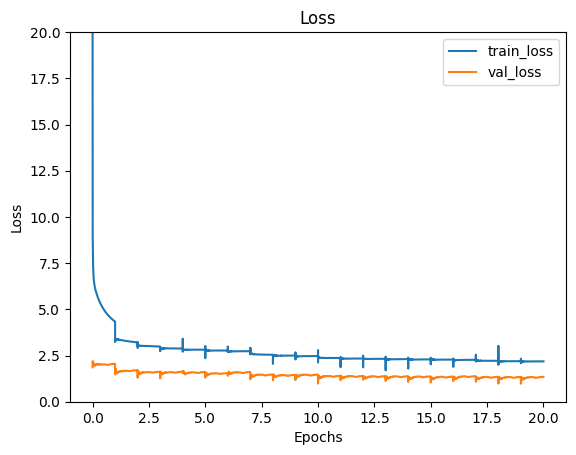

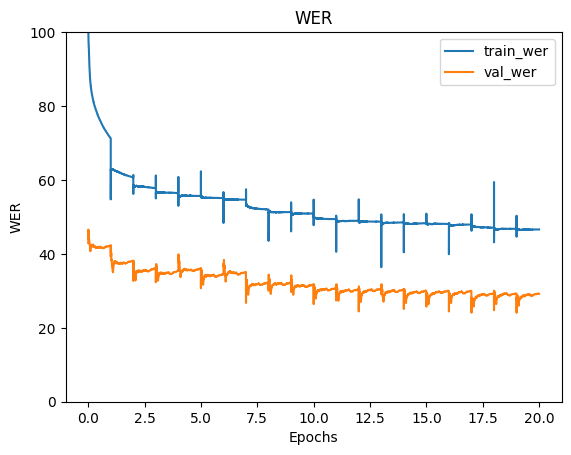

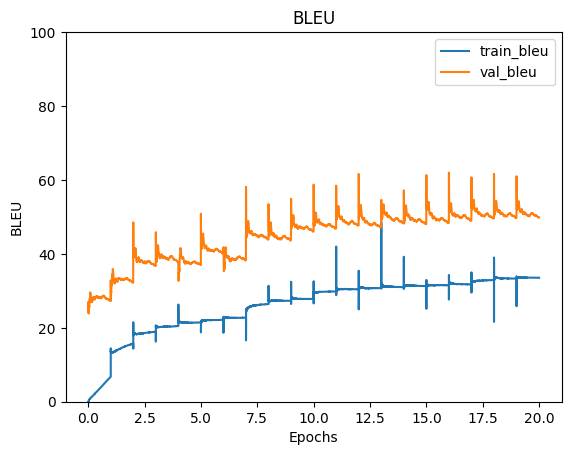

In [144]:
x = []
#print( len( history["train_loss"] ))
for i in range( len( history["train_loss"] )):
    x.append( i / 50000 )
    
v_x = []
#print( len( history["val_loss"]) )
for i in range( len( history["val_loss"]) ):
    v_x.append( i / 250 )

plt.title( "Loss")
plt.xlabel( "Epochs")
plt.ylabel( "Loss")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot( v_x, history["val_loss"], label="val_loss")
plt.ylim( 0, 20 )
plt.legend()
plt.show()

#plt.title( "Loss0")
#plt.xlabel( "Epochs")
#plt.ylabel( "Loss0")
#plt.plot(x, history["train_loss0"], label="train_loss0")
#plt.plot( v_x, history["val_loss0"], label="val_loss0")
#plt.ylim( 0, 10 )
#plt.legend()
#plt.show()

plt.title( "WER")
plt.xlabel( "Epochs")
plt.ylabel( "WER")
plt.plot(x, history["train_wer"], label="train_wer")
plt.plot( v_x, history["val_wer"], label="val_wer")
plt.ylim( 0, 100 )
plt.legend()
plt.show()

plt.title( "BLEU")
plt.xlabel( "Epochs")
plt.ylabel( "BLEU")
plt.plot(x, history["train_bleu"], label="train_bleu")
plt.plot( v_x, history["val_bleu"], label="val_bleu")
plt.ylim( 0, 100 )
plt.legend()
plt.show()

In [145]:
'''
test_text = "それは昭和初期の映画だと思います"
#日本語用のトークン変換関数を作成
j_t = Tokenizer()
def j_tokenizer(text): 
    return [tok for tok in j_t.tokenize(text, wakati=True)]

#test_text = "わたしは生きている"

test_text = j_tokenizer( test_text )

test_ids = [ idx_list[s] for s in test_text ]
test_ids.insert( 0, idx_list['<bos>'] )
test_ids.insert( 0, idx_list['<len>'] )
test_ids.append( idx_list['<eos>'])
'''
test_ids = [1, 6219, 64, 108, 8575, 9, 995, 628, 12749, 29, 5940, 133, 300, 42, 224, 46, 19, 2]

test_ids = torch.tensor( test_ids ).to( device )

sentence = [ token_list[str(i.item())] for i in test_ids ]

print( "sentence:", " ".join( sentence ))

test_ids = test_ids.unsqueeze( 0 )

#print( "test_ids:",test_ids )

# 正解の文字列を取得
caption = [1, 44, 4489, 6972, 1002, 32, 1513, 153, 15988, 11576, 13, 2]
reference = []
for m in caption:
    reference.append( token_list_en[str(m)])
    if m == idx_list_en['<eos>']:
        break    

print( "reference :", " ".join(reference))        

dec_input_lens = torch.ones( (test_ids.size(0) ) ) * test_ids.size(1)

#preds, lprobs, max_len, length_mask = inference( test_ids )
#preds, lprobs, max_len, length_mask = inference1( test_ids )
#preds, lprobs, max_len, length_mask = inference2( test_ids )
text = test_ids
outputs = model( text )

preds = torch.argmax( outputs, dim = 2 )

#print( "preds:", preds )

#pred = preds.squeeze( 0 )

#print( "size of pred:", pred.size() )

#hypotheses = preds 

#bsz = test_ids.size(0)
#length_beam_size = 2

#hypotheses = hypotheses.view(bsz, length_beam_size, max_len)
#lprobs = lprobs.view(bsz, length_beam_size)
#tgt_lengths = (1 - length_mask).sum(-1)
#avg_log_prob = lprobs / tgt_lengths.float()
#best_lengths = avg_log_prob.max(-1)[1]
#hypotheses = torch.stack([hypotheses[b, l, :] for b, l in enumerate(best_lengths)], dim=0)

#print( "size of hypotheses:", hypotheses.size())
pred = torch.squeeze( preds, dim = 0 )

print( "size of pred:", pred.size())

#print( pred )

#sent = []
#for m in pred:
#    #print( m )
#    sent.append( token_list_en[str(int(m.item()))])
#    if token_list_en[str(int(m.item()))] == '<eos>':
#        break
        
sent = ctc_simple_decode( pred, token_list_en)
    
print( 'hypotheses:', ' '.join(sent) )

# 認識誤りを計算
(error, substitute, 
    delete, insert, ref_length) = \
    levenshtein.calculate_error(reference, sent)

#bleu = bleu_score.sentence_bleu( refs, sent, smoothing_function=fn)
#print( refs )
#print( hypotheses )
bleu = bleu_score.sentence_bleu( [reference], sent)
#bleu = bleu_score1( refs, sent )
#print( bleu )
#bleu = bleu_score.sentence_bleu( reference, sent)


print( "WER:", error / len( sent )  * 100, "BLEU:", bleu * 100 )

sentence: <bos> 完成 し た 石鹸 は 通気 性 包装 に 保管 する 必要 が あり ます 。 <eos>
reference : <bos> the finished soap must be stored in breathable packaging . <eos>
size of pred: torch.Size([36])
hypotheses: <bos> the finished soap should be stored in breathable packaging
WER: 30.0 BLEU: 53.875513386547794


In [91]:
test_dataset = SequenceDataset( "20240531_ntt_ids_test_auto.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )

test_loader = DataLoader(test_dataset,
                        #batch_size=10,
                        batch_size=1,
                        shuffle=False,
                        num_workers=0)

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 2236
n: 2237
n: 2238
n: 2239
n: 2240
n: 2241
n: 2242
n: 2243
n: 2244
n: 2245
n: 2246
n: 2247
n: 2248
n: 2249
n: 2250
n: 2251
n: 2252
n: 2253
n: 2254
n: 2255
n: 2256
n: 2257
n: 2258
n: 2259
n: 2260
n: 2261
n: 2262
n: 2263
n: 2264
n: 2265
n: 2266
n: 2267
n: 2268
n: 2269
n: 2270
n: 2271
n: 2272
n: 2273
n: 2274
n: 2275
n: 2276
n: 2277
n: 2278
n: 2279
n: 2280
n: 2281
n: 2282
n: 2283
n: 2284
n: 2285
n: 2286
n: 2287
n: 2288
n: 2289
n: 2290
n: 2291
n: 2292
n: 2293
n: 2294
n: 2295
n: 2296
n: 2297
n: 2298
n: 2299
n: 2300
n: 2301
n: 2302
n: 2303
n: 2304
n: 2305
n: 2306
n: 2307
n: 2308
n: 2309
n: 2310
n: 2311
n: 2312
n: 2313
n: 2314
n: 2315
n: 2316
n: 2317
n: 2318
n: 2319
n: 2320
n: 2321
n: 2322
n: 2323
n: 2324
n: 2325
n: 2326
n: 2327
n: 2328
n: 2329
n: 2330
n: 2331
n: 2332
n: 2333
n: 2334
n: 2335
n: 2336
n: 2337
n: 2338
n: 2339
n: 2340
n: 2341
n: 2342
n: 2343
n: 2344
n: 2345
n: 2346
n: 2347
n: 2348
n: 2349
n: 2350
n: 2351
n: 2352
n: 2353
n: 2354
n: 2355
n: 2356
n: 2357
n: 2358
n: 2359
n: 2360


In [146]:
model.eval()
print("Test")

n = 0
total_error0 = 0
total_token_length0 = 0
total_bleu0 = 0
for i, (text, label, text_len, target_len) in enumerate(test_loader):
    #if i > 100:
    #if i > 10:
    if i > 50:
    #if i > 4000:
        break
    text, label, text_len, target_len = text.to(device), label.to(device), text_len.to(device), target_len.to(device)
    #print( "val i:", i )

    with torch.no_grad():

        #preds, _ = model( text, text_len )
        outputs = model( text )
        hypotheses = torch.argmax( outputs, dim = 2 )
  
    n2 = 0
    jap_sentence = []
    hypo_sentence = []
    ref_sentence = []
    total_error = 0
    total_token_length = 0
    test_loss = 0
    total_bleu = 0
    for hypo_id, caption, japa in zip( hypotheses, label, text):

        jap = []
        for m in japa:
            jap.append( token_list[str(m.item())])
            if m == idx_list['<eos>']:
                break
        #hypo = []
        #for m in hypo_id:
        #    #if token_list_en[str(int(m.item()))] != '<eos>':
        #    hypo.append(token_list_en[str(int(m.item()))])
        #    if m == idx_list_en['<eos>'] or m == idx_list_en['<pad>']:
        #    #if m == idx_list_en['<pad>']:
        #        break
        hypo = ctc_simple_decode( hypo_id, token_list_en)
        # 正解の文字列を取得
        reference = []
        for m in caption:
            reference.append( token_list_en[str(m.item())])
            if m == idx_list_en['<eos>']:
                break
                        
        # 認識誤りを計算
        (error, substitute, 
            delete, insert, ref_length) = \
            levenshtein.calculate_error(hypo,reference)

        bleu = bleu_score.sentence_bleu( [reference], hypo )

        
        total_bleu += bleu
        total_bleu0 += bleu
        total_error += error
        total_error0 += error
        total_token_length += ref_length
        total_token_length0 += ref_length

        jap_sentence.append( ''.join(jap))
        hypo_sentence.append( ' '.join(hypo) )
        ref_sentence.append( ' '.join(reference ) )
                    
        n2 += 1
        n += 1
        
       
    #if i % 200 == 199:
    print(f"index:{i+1}  WER: {total_error / total_token_length * 100:.10f}")
    print(f"index:{i+1}  BLEU:{total_bleu / n2 * 100: 10f}")
    for i2, (hypo_s, refe_s, jap_s ) in enumerate( zip( hypo_sentence, ref_sentence, jap_sentence ) ):
        print( "japa:", jap_s)
        print( "refe:", refe_s)
        print( "hypo:", hypo_s )

        
print(f"index:{i+1}  WER0: {total_error0 / total_token_length0 * 100:.10f}")
print(f"index:{i+1}  BLEU0:{total_bleu0 / n * 100: 10f}")


Test
index:1  WER: 8.3333333333
index:1  BLEU: 73.488892
japa: <bos>完成した石鹸は通気性包装に保管する必要があります。<eos>
refe: <bos> the finished soap must be stored in breathable packaging . <eos>
hypo: <bos> the finished soap should be stored in breathable packaging . <eos>
index:2  WER: 35.7142857143
index:2  BLEU: 25.400290
japa: <bos>そのような困難な仕事を占めた最初の会社はバッファローでした。<eos>
refe: <bos> the first company that occupied such a difficult task was buffalo . <eos>
hypo: <bos> the first company who occupied such difficult work was buffer low . <eos>
index:3  WER: 8.3333333333
index:3  BLEU: 73.488892
japa: <bos>最初の評議会は6月末にハッチングします。<eos>
refe: <bos> the first council hatches at the end of june . <eos>
hypo: <bos> the first council hatching at the end of june . <eos>
index:4  WER: 9.0909090909
index:4  BLEU: 81.761290
japa: <bos>最初に炭水化物、タンパク質、脂肪を含む。<eos>
refe: <bos> the first includes carbohydrates , proteins , fats . <eos>
hypo: <bos> first includes carbohydrates , proteins , fats . <eos>
index:5  WER: 20.000000000

index:31  WER: 28.5714285714
index:31  BLEU:  0.000000
japa: <bos>ネジ山の基礎は最も合理的なデザインです。<eos>
refe: <bos> the foundation on the screw piles is the most rational design . <eos>
hypo: <bos> the basis of the screw is the most reasonable design . <eos>
index:32  WER: 6.6666666667
index:32  BLEU: 81.535510
japa: <bos>フレームが内側にノックアウトされており、釘は外側に曲がっています。<eos>
refe: <bos> the frame is knocked out inside , and nails are bent outside . <eos>
hypo: <bos> the frame is knocked out inside , and the nails are bent outside . <eos>
index:33  WER: 13.3333333333
index:33  BLEU: 61.047358
japa: <bos>フレームワークはボードや木の杭の冬に設置されています。<eos>
refe: <bos> the framework is installed for the winter of boards or wooden piles . <eos>
hypo: <bos> the framework is installed in the winter of boards or wooden pile . <eos>
index:34  WER: 51.8518518519
index:34  BLEU: 21.909989
japa: <bos>無料版にはカレンダーモジュールを搭載したモダンなスキャナが含まれています。 これにより、疑わしいファイルを監視するための検疫モジュール、検証レポートのログ、および約500,000の署名を含む巨大なベースの検疫モジュールがあります。<eos>
refe: <bos> the free ve